In [1]:
import autogluon as ag
import mxnet as mx
import mxnet.gluon.nn as nn


Bad key "text.kerning_factor" on line 4 in
/trinity/home/k.chertoganov/anaconda6/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
class Identity(mx.gluon.HybridBlock):
    def hybrid_forward(self, F, x):
        return x

class ConvBNReLU(mx.gluon.HybridBlock):
    def __init__(self, in_channels, channels, kernel, stride):
        super().__init__()
        padding = (kernel - 1) // 2
        self.conv = nn.Conv2D(channels, kernel, stride, padding, in_channels=in_channels)
        self.bn = nn.BatchNorm(in_channels=channels)
        self.relu = nn.Activation('relu')
    def hybrid_forward(self, F, x):
        return self.relu(self.bn(self.conv(x)))

In [3]:
from autogluon.contrib.enas import *

@enas_unit()
class ResUnit(mx.gluon.HybridBlock):
    def __init__(self, in_channels, channels, hidden_channels, kernel, stride):
        super().__init__()
        self.conv1 = ConvBNReLU(in_channels, hidden_channels, kernel, stride)
        self.conv2 = ConvBNReLU(hidden_channels, channels, kernel, 1)
        if in_channels == channels and stride == 1:
            self.shortcut = Identity()
        else:
            self.shortcut = nn.Conv2D(channels, 1, stride, in_channels=in_channels)
    def hybrid_forward(self, F, x):
        return self.conv2(self.conv1(x)) + self.shortcut(x)

In [4]:
mynet = ENAS_Sequential(
    ResUnit(1, 8, hidden_channels=ag.space.Categorical(4, 8), kernel=ag.space.Categorical(3, 5), stride=2),
    ResUnit(8, 8, hidden_channels=8, kernel=ag.space.Categorical(3, 5), stride=2),
    ResUnit(8, 16, hidden_channels=8, kernel=ag.space.Categorical(3, 5), stride=2),
    ResUnit(16, 16, hidden_channels=8, kernel=ag.space.Categorical(3, 5), stride=1, with_zero=True),
    ResUnit(16, 16, hidden_channels=8, kernel=ag.space.Categorical(3, 5), stride=1, with_zero=True),
    nn.GlobalAvgPool2D(),
    nn.Flatten(),
    nn.Activation('relu'),
    nn.Dense(10, in_units=16),
)

mynet.initialize()

#mynet.graph

# Data

In [5]:
x = mx.nd.random.uniform(shape=(1, 1, 28, 28))
y = mynet.evaluate_latency(x)

In [6]:
x


[[[[5.67846000e-01 1.72195703e-01 6.21169269e-01 8.50760788e-02
    4.98179555e-01 4.52728868e-01 8.66788566e-01 9.32665527e-01
    6.27734780e-01 7.63164997e-01 4.01427954e-01 3.11486065e-01
    4.16691750e-01 8.88615489e-01 8.10838640e-01 6.97274268e-01
    3.48191947e-01 4.63344008e-01 2.11454794e-01 2.64619529e-01
    5.93831837e-02 5.75533867e-01 8.76026869e-01 1.94901004e-01
    9.18546438e-01 7.41231680e-01 1.20120175e-01 9.36927855e-01]
   [3.34473729e-01 6.59267843e-01 1.75372064e-01 7.24994123e-01
    1.15898475e-01 1.64488405e-01 8.99866760e-01 7.48223960e-01
    5.68772629e-02 4.97356832e-01 9.80485678e-01 8.73826966e-02
    9.64508578e-02 3.86447400e-01 8.63470674e-01 7.29448140e-01
    5.66506088e-01 5.78210354e-01 3.67917478e-01 3.06382656e-01
    3.42342377e-01 9.88749027e-01 7.57364154e-01 5.74031830e-01
    3.14573288e-01 9.44949210e-01 6.57318890e-01 5.59774220e-01]
   [5.17326057e-01 5.64666510e-01 4.84965652e-01 5.11704348e-02
    9.01162148e-01 8.08278024e-01 5.9

In [7]:
y


[[ 1.1093837e-04  8.0205886e-05  2.9831970e-04 -1.1762418e-04
  -4.2643114e-05 -3.0894258e-05 -1.4834681e-04  1.1237406e-04
   1.1552517e-04 -3.8411064e-05]]
<NDArray 1x10 @cpu(0)>

In [8]:
print('Average latency is {:.2f} ms, latency of the current architecture is {:.2f} ms'.format(mynet.avg_latency, mynet.latency))

Average latency is 1.98 ms, latency of the current architecture is 2.18 ms


In [9]:
mynet.nparams

8714

In [10]:
reward_fn = lambda metric, net: metric * ((net.avg_latency / net.latency) ** 0.1)

# Start Training

In [11]:
scheduler = ENAS_Scheduler(mynet, train_set='mnist',
                           reward_fn=reward_fn, batch_size=128, num_gpus=1,
                           warmup_epochs=0, epochs=1, controller_lr=3e-3,
                           plot_frequency=10, update_arch_frequency=5)

get_built_in_dataset mnist


get_built_in_dataset mnist


In [12]:
scheduler

In [13]:
scheduler.run()

# The resulting architecture is

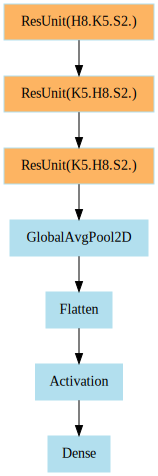

In [14]:
mynet.graph

In [15]:
reward_fn = lambda metric, net: metric * ((net.avg_latency / net.latency) ** 0.8)
mynet.initialize(force_reinit=True)
scheduler = ENAS_Scheduler(mynet, train_set='mnist',
                           reward_fn=reward_fn, batch_size=128, num_gpus=1,
                           warmup_epochs=0, epochs=1, controller_lr=3e-3,
                           plot_frequency=10, update_arch_frequency=5)
scheduler.run()

get_built_in_dataset mnist
get_built_in_dataset mnist


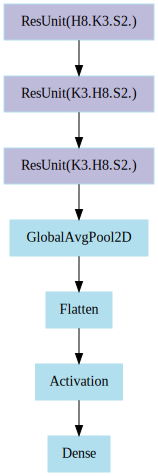

In [16]:
mynet.graph

In [17]:
mynet.export('enas')

AssertionError: 

In [18]:
mynet_static = mx.gluon.nn.SymbolBlock.imports("enas-symbol.json", ['data'], "enas.params")
y = mynet_static(mx.nd.zeros((1, 1, 28, 28)))
print(y.shape)

MXNetError: [16:25:42] src/io/local_filesys.cc:209: Check failed: allow_null:  LocalFileSystem::Open "enas.params": No such file or directory
Stack trace:
  [bt] (0) /trinity/home/k.chertoganov/anaconda6/lib/python3.7/site-packages/mxnet/libmxnet.so(+0x2ea6de8) [0x1554f52f4de8]
  [bt] (1) /trinity/home/k.chertoganov/anaconda6/lib/python3.7/site-packages/mxnet/libmxnet.so(+0x2e9e9ba) [0x1554f52ec9ba]
  [bt] (2) /trinity/home/k.chertoganov/anaconda6/lib/python3.7/site-packages/mxnet/libmxnet.so(MXNDArrayLoad+0x23d) [0x1554f497b5ed]
  [bt] (3) /trinity/home/k.chertoganov/anaconda6/lib/python3.7/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x15554c464ec0]
  [bt] (4) /trinity/home/k.chertoganov/anaconda6/lib/python3.7/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x15554c46487d]
  [bt] (5) /trinity/home/k.chertoganov/anaconda6/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x15554c67a1de]
  [bt] (6) /trinity/home/k.chertoganov/anaconda6/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(+0x12c14) [0x15554c67ac14]
  [bt] (7) /trinity/home/k.chertoganov/anaconda6/bin/python(_PyObject_FastCallKeywords+0x48b) [0x5555556ca18b]
  [bt] (8) /trinity/home/k.chertoganov/anaconda6/bin/python(_PyEval_EvalFrameDefault+0x52cf) [0x555555719e8f]

